# Libreries

In [260]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



# Reading the Data

In [2]:
Customers = pd.read_csv("CUSTOMERS.csv")
Geo_location = pd.read_csv("GEO_LOCATION.csv")
Order_items = pd.read_csv("ORDER_ITEMS.csv")
Order_payment = pd.read_csv("ORDER_PAYMENTS.csv")
Order_review_rating = pd.read_csv("ORDER_REVIEW_RATINGS.csv")
Orders = pd.read_csv("ORDERS.csv")
Products = pd.read_csv("PRODUCTS.csv")
Sellers = pd.read_csv("SELLERS.csv")

## An Overview from the Data

In [3]:
# collection for each dataset
Dataset = [Customers,Geo_location,Order_items,Order_payment,Order_review_rating,Orders,Products,Sellers]
Names = ["Customers","Geo_location","Order_items","Order_payment","Order_review_rating","Orders","Products","Sellers"]

# Creating a DataFrame with useful information about all datasets
Data_info = pd.DataFrame({})
Data_info["Dataset"] = Names
Data_info["n_rows"] =[ df.shape[0] for df in Dataset]
Data_info["n_cols"] =[ df.shape[1] for df in Dataset]
Data_info["null_amounts"] = [df.isnull().sum().sum() for df in Dataset]
Data_info['qty_null_columns'] = [len([col for col,null in df.isnull().sum().items() if null > 0]) for df in Dataset]
Data_info['null_columns'] = [", ".join([col for col,null in df.isnull().sum().items() if null > 0 ]) for df in Dataset]



#displaying data info
Data_info.style.background_gradient()

,Dataset,n_rows,n_cols,null_amounts,qty_null_columns,null_columns
0,Customers,99441,5,0,0,
1,Geo_location,19015,5,0,0,
2,Order_items,112650,7,0,0,
3,Order_payment,103886,5,0,0,
4,Order_review_rating,100000,5,0,0,
5,Orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,Products,32951,9,2461,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,Sellers,3095,4,114,2,"seller_city, seller_state"


In [4]:
df_overview = pd.DataFrame(columns=["dataset", "feature", "null_quantity", "null_percent", "data_type"])

for name, df in zip(Names, Dataset):
    for i in df.columns:
        null_quantity = df[i].isnull().sum().sum()
        null_percent = (null_quantity / df[i].shape[0]) * 100
        data_type = df[i].dtype
        df_overview = df_overview.append({
            "dataset": name,
            "feature": i,
            "null_quantity": null_quantity,
            "null_percent": null_percent,
            "data_type": data_type
        }, ignore_index=True)



#displaying data overview
df_overview.style.background_gradient(subset = ["null_percent","null_quantity"])

,dataset,feature,null_quantity,null_percent,data_type
0,Customers,customer_id,0,0.000000,object
1,Customers,customer_unique_id,0,0.000000,object
2,Customers,customer_zip_code_prefix,0,0.000000,int64
3,Customers,customer_city,0,0.000000,object
4,Customers,customer_state,0,0.000000,object
5,Geo_location,geolocation_zip_code_prefix,0,0.000000,int64
6,Geo_location,geolocation_lat,0,0.000000,float64
7,Geo_location,geolocation_lng,0,0.000000,float64
8,Geo_location,geolocation_city,0,0.000000,object
9,Geo_location,geolocation_state,0,0.000000,object


# Exploratory Data Analysis

## Total Orders on E-Commerce

### Analyzing using order status

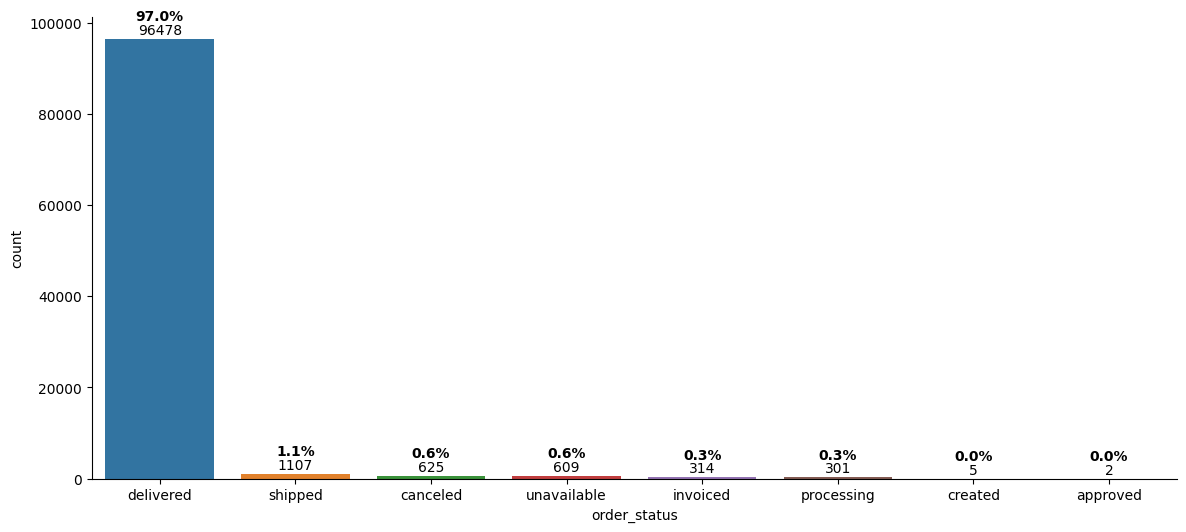

In [5]:
df_orders = Orders.merge(Customers, how='left', on='customer_id')
status = df_orders.groupby("order_status")[["order_status"]].count()
status.rename(columns = {"order_status" : "count"},inplace = True)
status.sort_values(by ="count",ascending = False, inplace = True)
status = status.reset_index()

#Ploting the graph on order status
fig, ax = plt.subplots(figsize=(14, 6))

# create the bar plot using seaborn
sns.barplot(x="order_status", y="count", data=status, ax=ax)
sns.despine()
# add count and percentage on annotation bar
for i,v in enumerate(status["count"]):
    ax.text(i,v+1000,str(v),ha ="center")
# adding percentage
    total = status["count"].sum()
    percentage = (v/total)*100
    ax.text(i,v+4000, f"{percentage:.1f}%",ha ="center",fontweight="bold")
    

* By the time this dataset was created, the highest amount of orders went from delivered ones. Only 3% of all orders came from the other status.

### Evaluate the e-commerce scenario using time attributes.


In [63]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].dt.year
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].dt.month
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].dt.strftime("%B")
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].dt.strftime("%Y""-""%m")
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].dt.strftime('%Y/%m/%d')


df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].dt.day
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].dt.dayofweek
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].dt.strftime('%a')

df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].dt.hour

hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']

df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

In [64]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,10/10/2017 21:25,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017,10,October,2017-10,2017/10/02,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,8/7/2018 15:27,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018,7,July,2018-07,2018/07/24,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,8/17/2018 18:06,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018,8,August,2018-08,2018/08/08,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,2017-11-18 19:45:00,2017-11-22 13:39:00,12/2/2017 0:28,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017,11,November,2017-11,2017/11/18,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2018-02-13 22:20:00,2018-02-14 19:46:00,2/16/2018 18:17,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2018,2,February,2018-02,2018/02/13,13,1,Tue,21,Night


### Growing trend on  e-commerce business

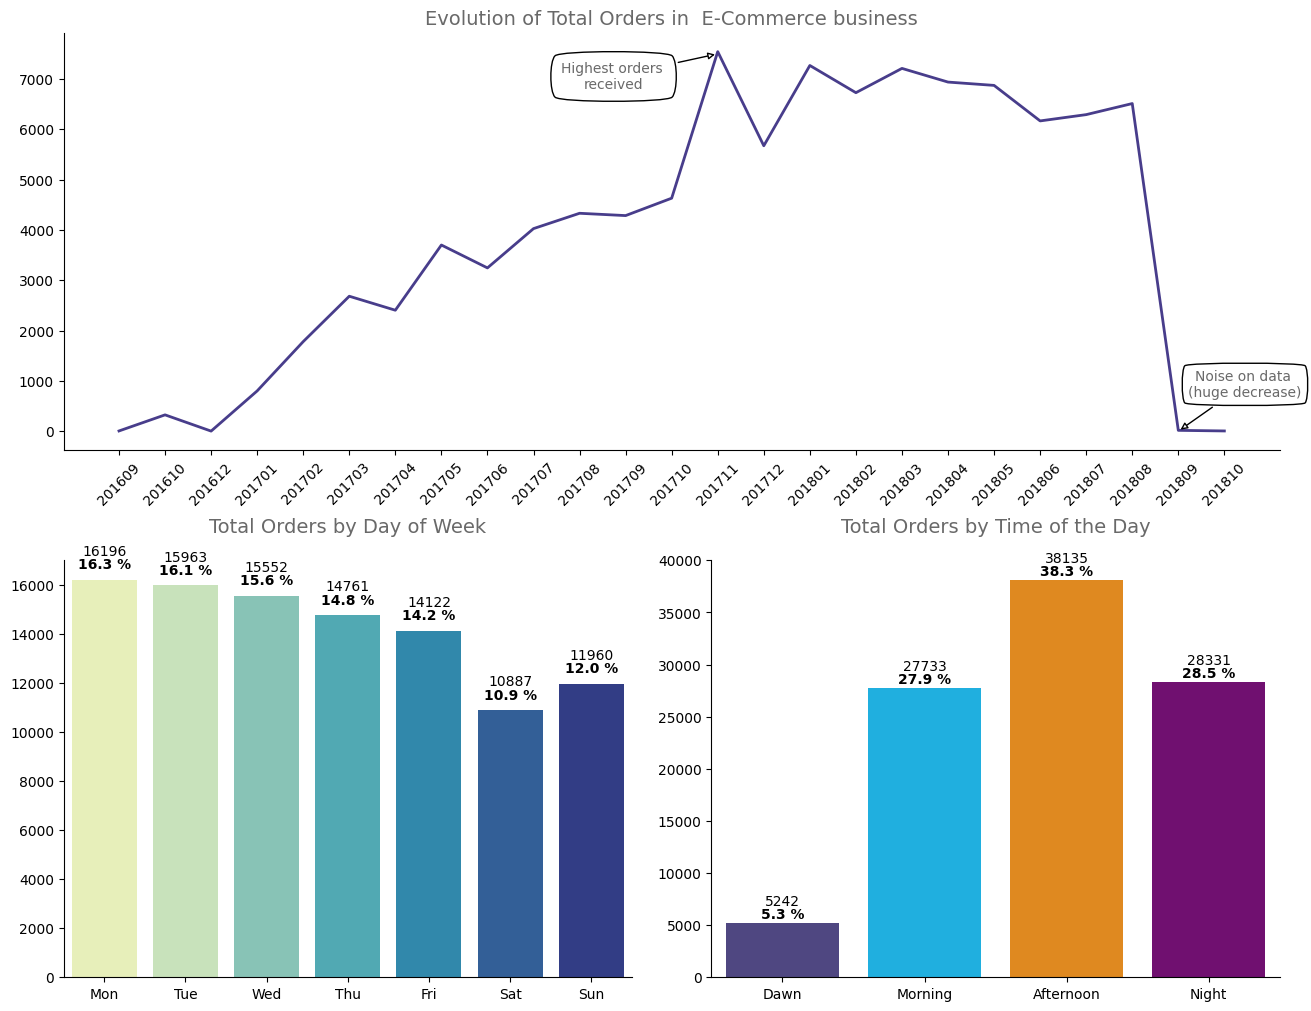

In [562]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
sns.despine()
ax1.set_ylabel('')
ticks = df_orders['order_purchase_year_month'].value_counts().sort_index().index
ax1.set_xticks(range(len(ticks)))
ax1.set_xticklabels(ticks, rotation=45)

ax1.set_title('Evolution of Total Orders in  E-Commerce business', size=14, color='dimgrey')


# Barchart - Total of orders by day of week
sns.barplot(data =df_orders,x = df_orders["order_purchase_dayofweek"].value_counts().sort_index().index,y = df_orders["order_purchase_dayofweek"].value_counts().sort_index().values ,ax = ax2,  palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)
for i , v in enumerate(df_orders["order_purchase_dayofweek"].value_counts().sort_index()):
    ax2.text(i,v+1000,str(v),ha ="center")
    total = df_orders["order_purchase_dayofweek"].value_counts().sum()
    percentage = (v/total)*100
    ax2.text(i,v+450,f"{percentage:.1f} %",ha ="center",fontweight="bold")
    
# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
sns.barplot(data =df_orders,x = df_orders["order_purchase_time_day"].value_counts().sort_index().index,y = df_orders["order_purchase_time_day"].value_counts().sort_index().values ,ax = ax3,  palette=day_color_list)
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)
for i , v in enumerate(df_orders["order_purchase_time_day"].value_counts().sort_index()):
    ax3.text(i,v+1700,str(v),ha ="center")
    total = df_orders["order_purchase_time_day"].value_counts().sum()
    percentage = (v/total)*100
    ax3.text(i,v+450,f"{percentage:.1f} %",ha ="center",fontweight="bold")
    

By the chart above we can conclude:

* E-commerce on business really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
* Monday are the prefered day for brazilian's customers and they tend to buy more at afternoons.

### Customer Acquisition by Month

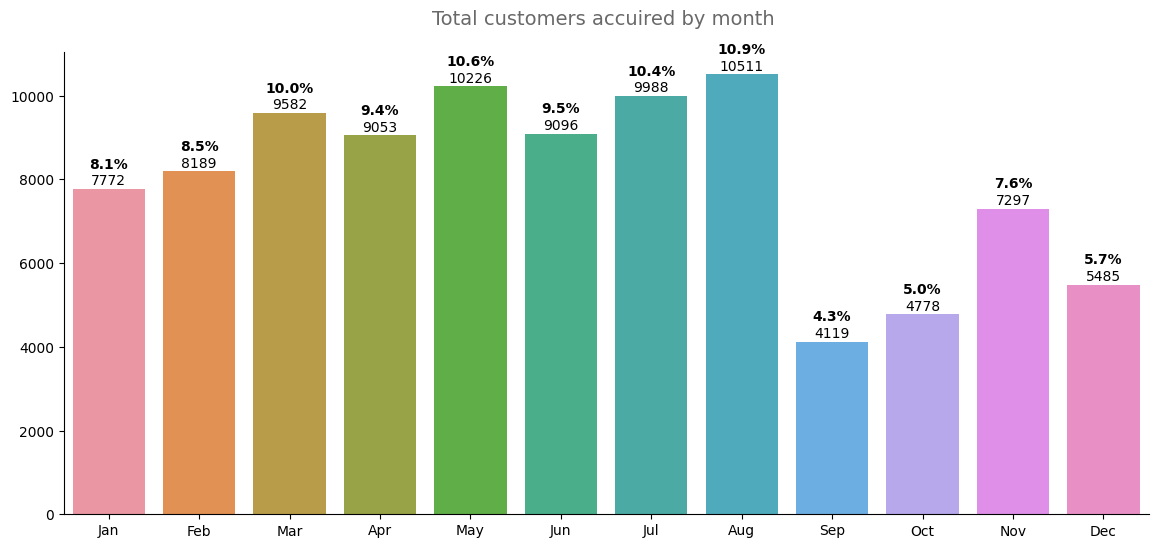

In [9]:
unique_cust = df_orders[["customer_unique_id","order_purchase_month"]].drop_duplicates(subset = "customer_unique_id" )
#Ploting the graph on order status
fig, ax = plt.subplots(figsize=(14, 6))

# create the bar plot using seaborn
sns.barplot(x=unique_cust["order_purchase_month"].value_counts().sort_index().index, y=unique_cust["order_purchase_month"].value_counts().sort_index().values, data=unique_cust, ax=ax)
sns.despine()
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(month_label)
ax.set_title('Total customers accuired by month ', size=14, color='dimgrey', pad=20)
# add count and percentage on annotation bar
for i,v in enumerate(unique_cust["order_purchase_month"].value_counts().sort_index()):
    ax.text(i,v+100,str(v),ha ="center")
    # adding percentage
    total = unique_cust["order_purchase_month"].value_counts().sum()
    percentage = (v/total)*100
    ax.text(i,v+500, f"{percentage:.1f}%",ha ="center",fontweight="bold")


* Most of the customer acquisition takes place in the month of August, while the least number of customer acquisitions happen in September.

### E-commerce: a comparison between 2017 and 2018

### E-Commerce Impact on Economy

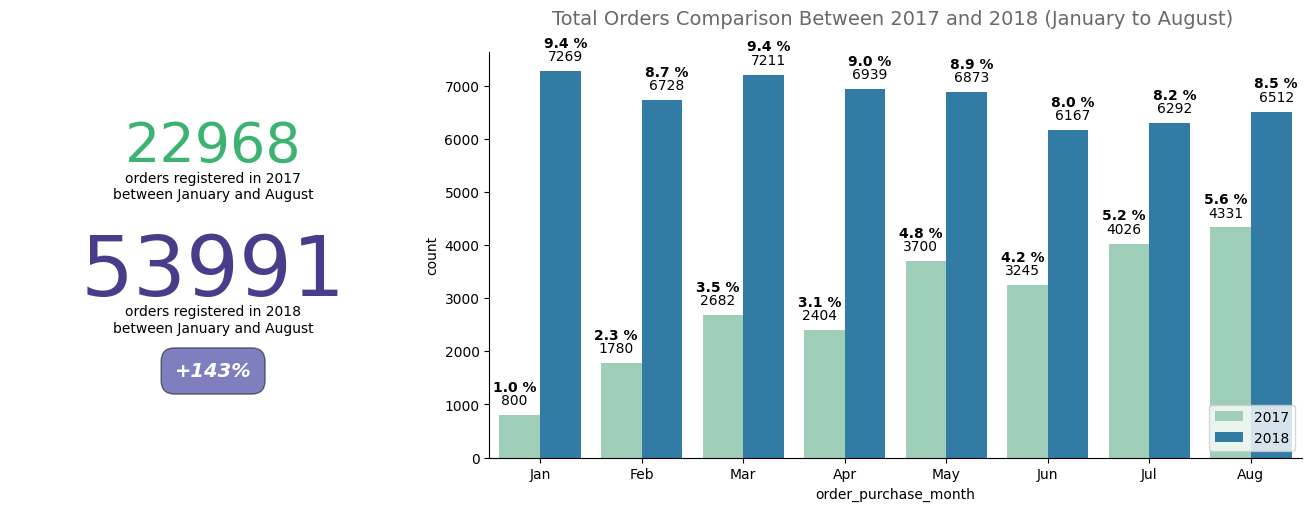

In [53]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))
# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.5, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.5, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.5, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.5, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.5, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')



Data = pd.DataFrame(df_orders_compare[["order_purchase_month","order_purchase_year"]].value_counts().reset_index())
sns.barplot(x= Data.iloc[:,0], y=Data.iloc[:,2], hue = Data.iloc[:,1], data=Data,ax=ax2,palette='YlGnBu' )
sns.despine()
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_ylabel("count")
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August) ', size=14, color='dimgrey', pad=20)
plt.legend(loc='lower right')

Data.sort_values(by =["order_purchase_month","order_purchase_year"], inplace = True,ignore_index = True)
for i , v in enumerate(Data[0]):
    ax2.text((i-.5)/2,v+200,str(v),ha ="center")
    total = Data[0].sum()
    percentage = (v/total)*100
    ax2.text((i-.5)/2,v+450,f"{percentage:.1f} %",ha ="center",fontweight="bold")


plt.show()



In [76]:
# Merging orders and order_items
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].dt.strftime("%Y%m")
df_orders_items = df_orders.merge(Order_items, how='left', on='order_id')

# # Filtering data between 2017-01 and 2018-08

df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

,order_purchase_year,order_purchase_year_month,order_id,price,freight_value,price_per_order,freight_per_order
0,2017,201701,966,120312.87,16875.62,124.547484,17.469586
1,2017,201702,1998,247303.02,38977.60,123.775285,19.508308
2,2017,201703,3041,374344.30,57704.29,123.099079,18.975432
3,2017,201704,2697,359927.23,52495.01,133.454664,19.464223
4,2017,201705,4176,506071.14,80119.81,121.185618,19.185778


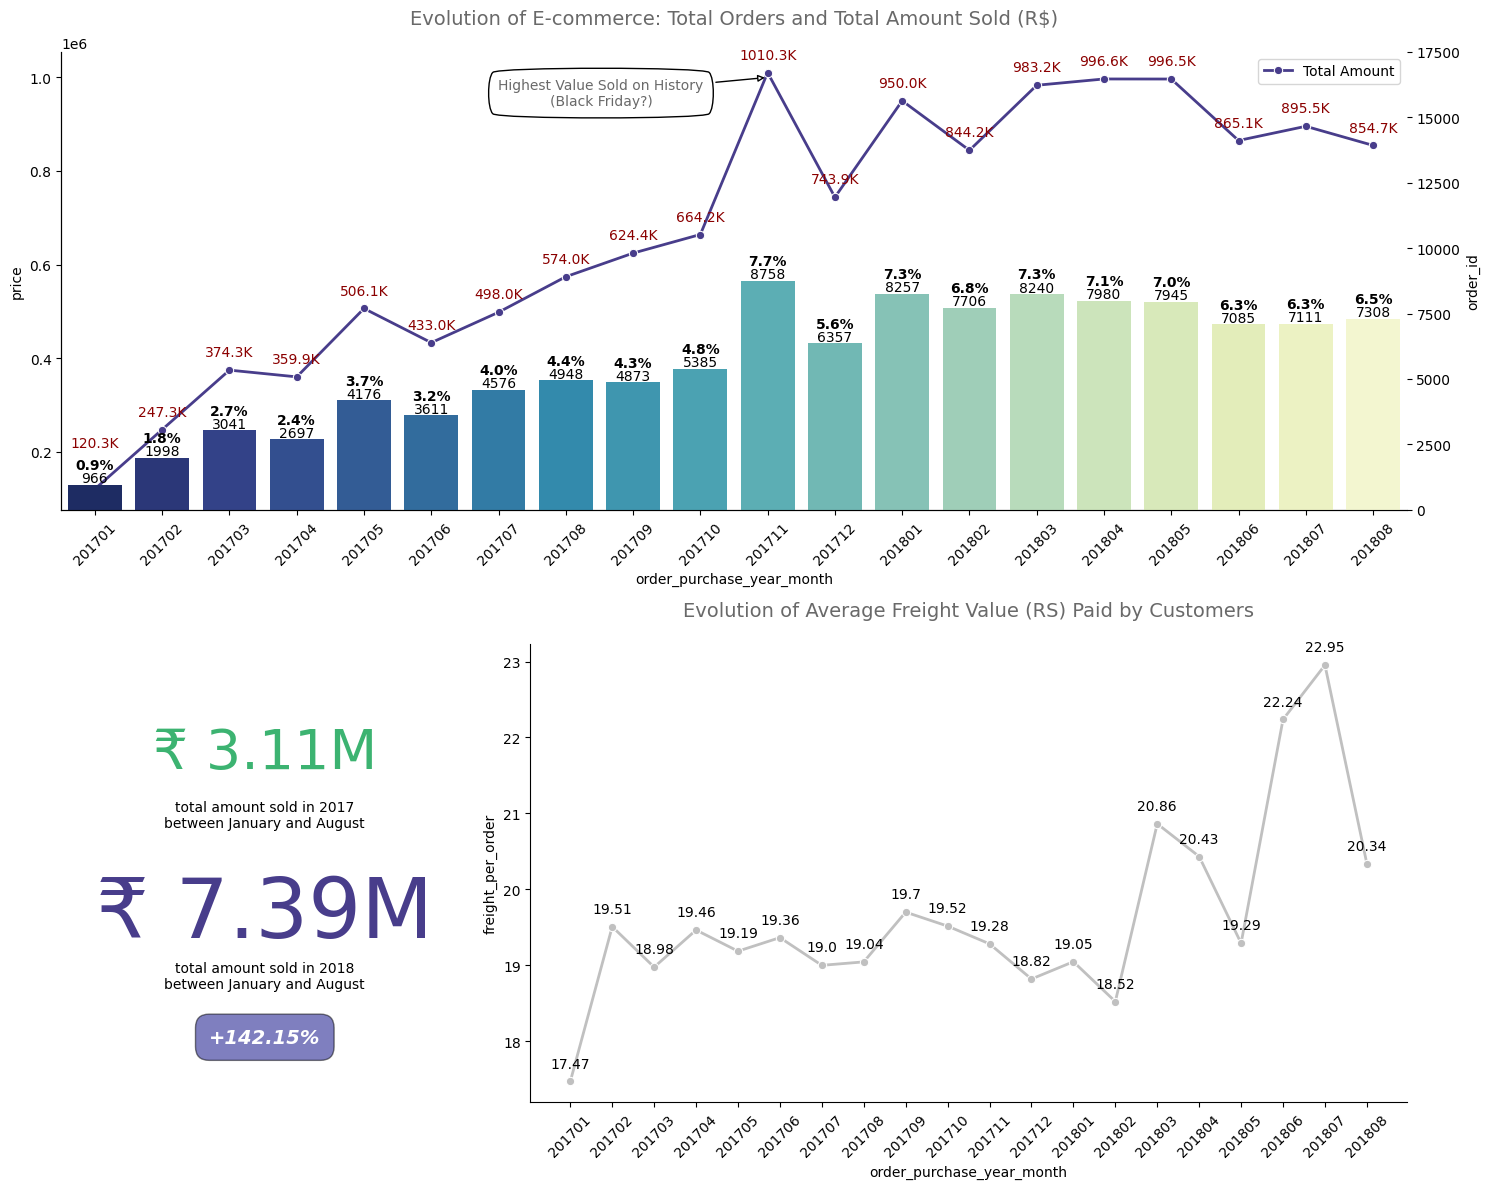

In [146]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis Definition
gs = GridSpec(2,3,figure = fig)
ax1 = fig.add_subplot(gs[0 ,:])
ax2 = fig.add_subplot(gs[1 ,0])
ax3 = fig.add_subplot(gs[1 ,1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()

sns.barplot(x="order_purchase_year_month", y="order_id", data=df_month_aggreg, ax=ax1_twx, palette='YlGnBu_r')   
sns.despine()
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# add count and percentage on annotation bar
for i, v in enumerate(df_month_aggreg["order_id"]):
    ax1_twx.text(i, v+100, v, ha="center")
    # adding percentage
    total = df_month_aggreg["order_id"].sum()
    percentage = (v/total)*100
    ax1_twx.text(i, v+600, f"{percentage:.1f}%", ha="center", fontweight="bold")


for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    if x == 0 :
        ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 30),
                    ha='center', color='#8B0000')
    else:
        ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                    ha='center', color='#8B0000')
        
ax1.annotate(f'Highest Value Sold on History\n(Black Friday?)', (10, 1000000), xytext=(-120, -20), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')

sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()

growth = 1 + (sold_2017 / sold_2018)

ax2.text(0.50, 0.73, '\u20B9 ' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, '\u20B9 ' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)

for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='black')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

### Total sales by state

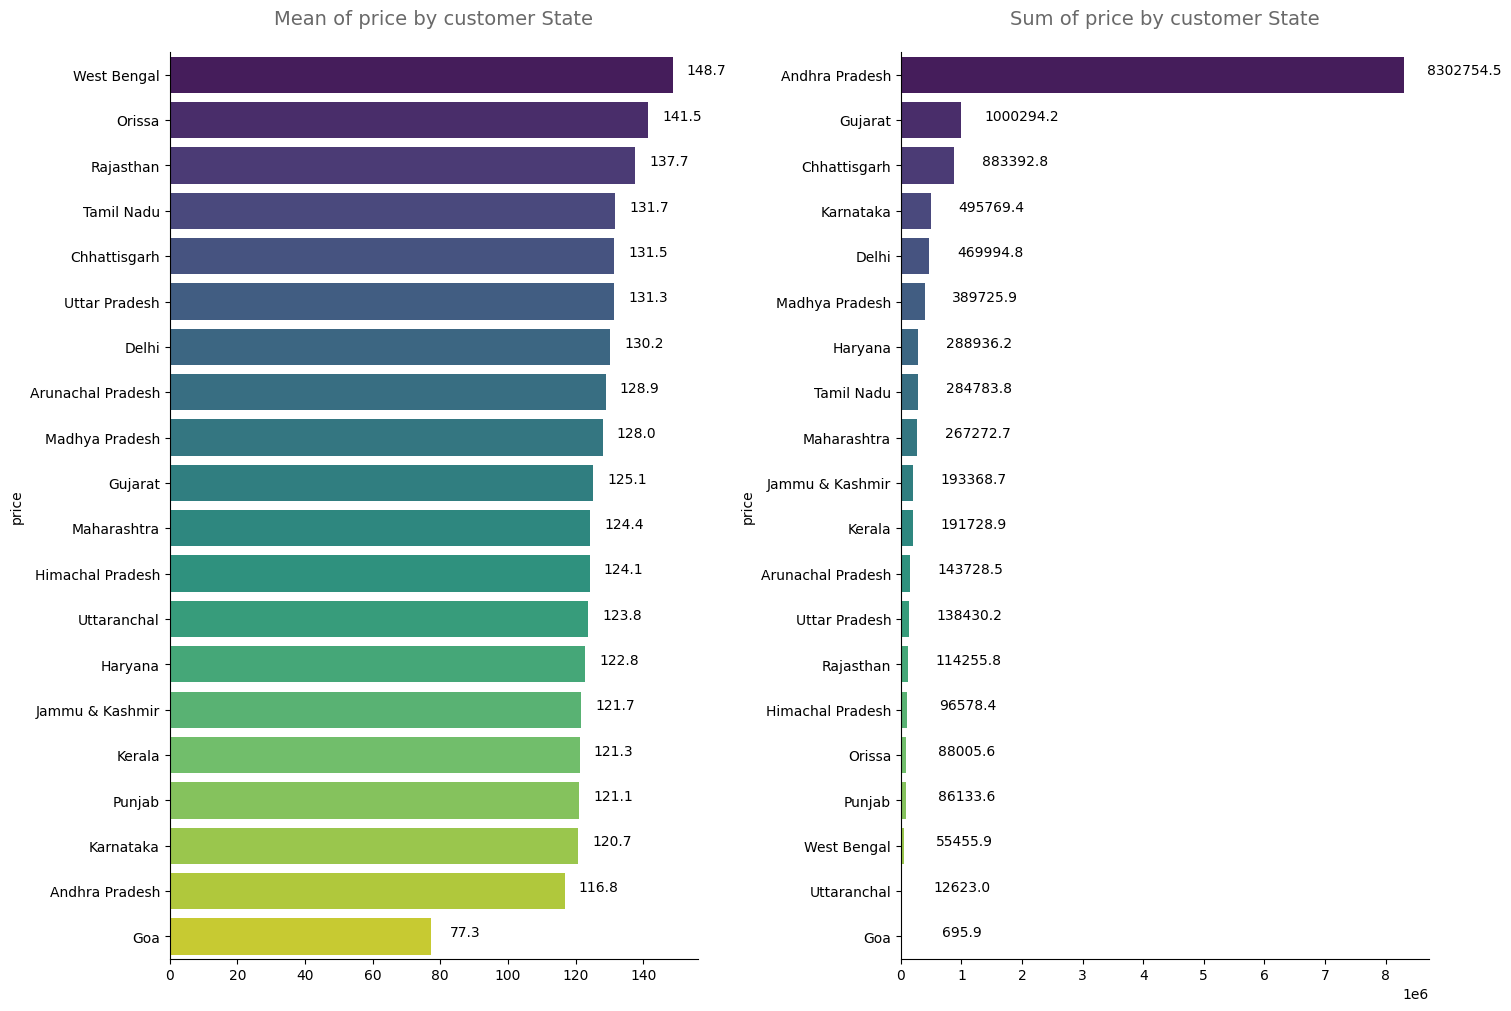

In [242]:
df_orders_filt_new = df_orders_filt.merge(Geo_location,how = "left",left_on ="customer_zip_code_prefix",right_on = "geolocation_zip_code_prefix")
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
# Axis Definition
gs = GridSpec(2,2,figure = fig)
ax1 = fig.add_subplot(gs[: ,0])
ax2 = fig.add_subplot(gs[: ,1])

#  mean price  by state
sns.barplot(y = df_orders_filt_new.groupby("geolocation_state")["price"].mean().index,x = df_orders_filt_new.groupby("geolocation_state")["price"].mean().sort_values(ascending = False).values, 
            data = df_orders_filt_new, orient='h',palette='viridis', ax = ax1 )
sns.despine()
ax1.set_ylabel("price")
ax1.set_title('Mean of price by customer State', size=14, color='dimgrey', pad=20)
state =  df_orders_filt_new.groupby("geolocation_state")["price"].mean().sort_values(ascending = False).index
ax1.set_yticklabels(state)
for i , v in enumerate(df_orders_filt_new.groupby("geolocation_state")["price"].mean().sort_values(ascending = False).values):
    ax1.text(v+10, i,str(round(v,1)),ha ="center")
# sum price value by state
sns.barplot(y = df_orders_filt_new.groupby("geolocation_state")["price"].sum().sort_values(ascending = False).index,x = df_orders_filt_new.groupby("geolocation_state")["price"].sum().sort_values(ascending = False).values, 
            data = df_orders_filt_new, orient='h',palette='viridis' )
sns.despine()
ax2.set_yticklabels(df_orders_filt_new.groupby("geolocation_state")["price"].mean().index)
ax2.set_ylabel("price")
ax2.set_title('Sum of price by customer State', size=14, color='dimgrey', pad=20)
state =  df_orders_filt_new.groupby("geolocation_state")["price"].sum().sort_values(ascending = False).index
ax2.set_yticklabels(state)
for i , v in enumerate(df_orders_filt_new.groupby("geolocation_state")["price"].sum().sort_values(ascending = False).values):
    ax2.text(v+1000000, i,str(round(v,1)),ha ="center")

It's very interesting to see how some states have a high total amount sold and a low price per order. If we look at Andhra pradesh for example, it's possible to see that it is the state with most valuable state for e-commerce (83,02,754 sold) but it is also where customers pay less per order (116.8 per order).

### State-wise comparison
###### An analysis on sales, freight and delivery time

In [397]:
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date','order_estimated_delivery_date', 'order_delivered_customer_date']

for col in date_cols:
    df_orders_filt[col] = pd.to_datetime(df_orders_filt[col])
# removing null value
df_orders_filt.dropna(subset=['order_estimated_delivery_date', 'order_delivered_customer_date', 'order_purchase_timestamp'], inplace=True)
# Calculating working days between purchasing, delivering and estimated delivery
purchasing = pd.to_datetime(df_orders_filt['order_purchase_timestamp']).dt.date.apply(datetime.date.toordinal).apply(datetime.datetime.fromordinal)
delivered = pd.to_datetime(df_orders_filt['order_delivered_customer_date']).dt.date.apply(datetime.date.toordinal).apply(datetime.datetime.fromordinal)
estimated = pd.to_datetime(df_orders_filt['order_estimated_delivery_date']).dt.date.apply(datetime.date.toordinal).apply(datetime.datetime.fromordinal)

df_orders_filt['time_to_delivery'] = np.busday_count(purchasing.values.astype('datetime64[D]'), delivered.values.astype('datetime64[D]'))
df_orders_filt['diff_estimated_delivery'] =  np.busday_count(estimated.values.astype('datetime64[D]'), delivered.values.astype('datetime64[D]'))

# Grouping data by state
states_avg_grouped = df_orders_filt.groupby(by='customer_state', as_index=False).mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]


# Sorting data
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery', ascending=False)
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery')

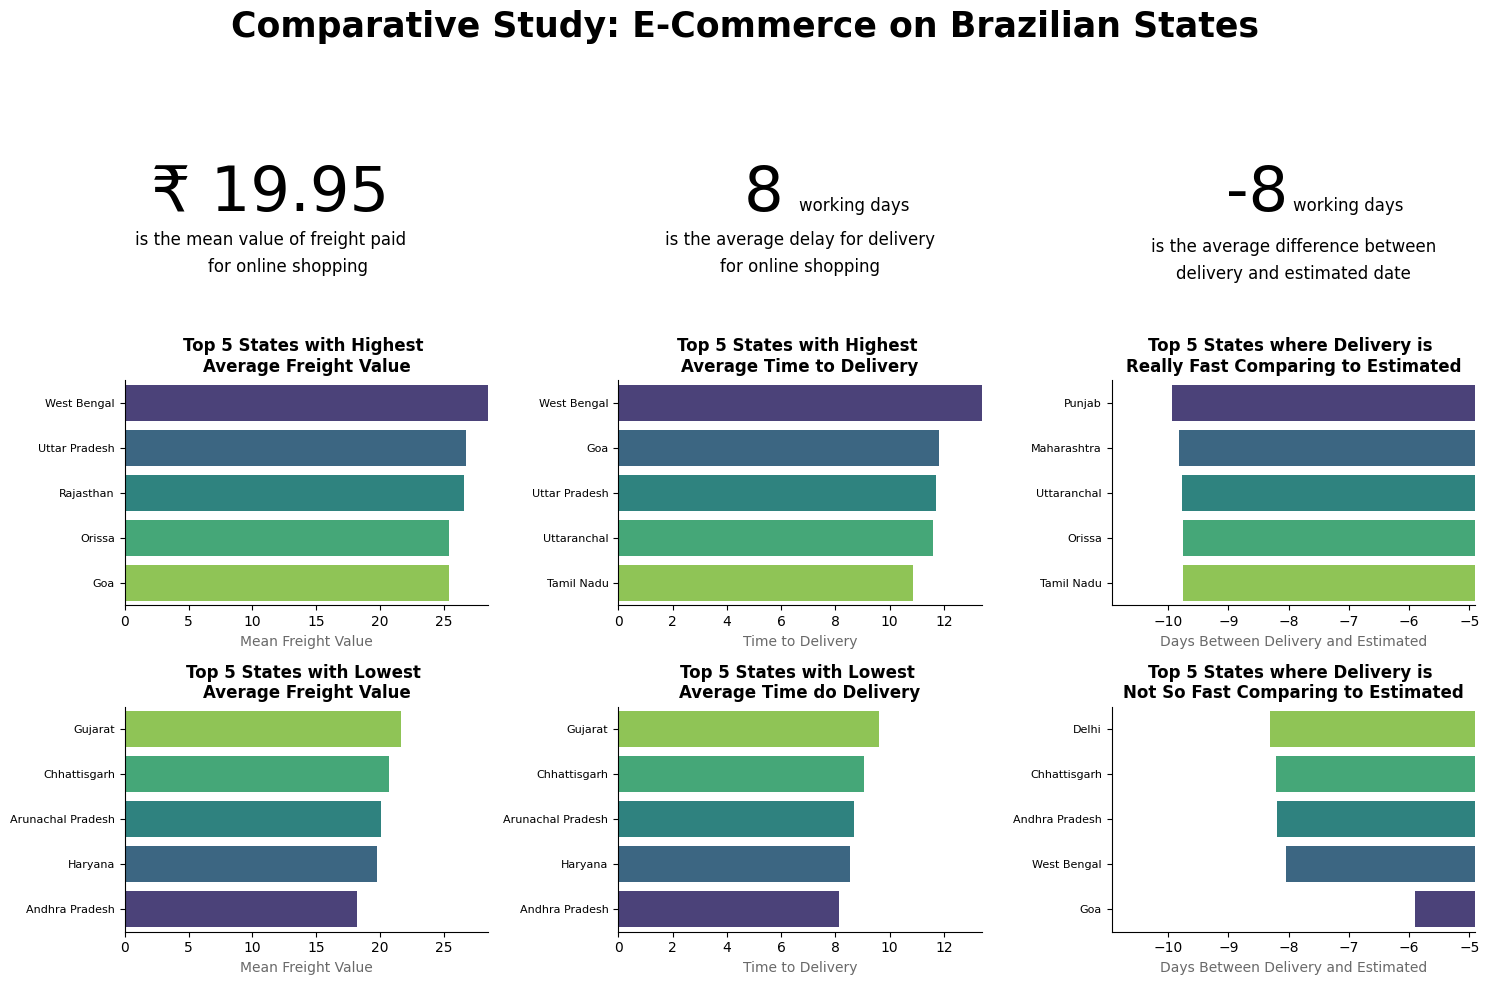

In [486]:
# plotinh graphs
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.head(), ax=axs[1, 0], palette='viridis')
sns.despine()
axs[1, 0].set_title('Top 5 States with Highest \nAverage Freight Value', size=12, color='black',fontweight = "bold")
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.tail(), ax=axs[2, 0], palette='viridis_r')
axs[2, 0].set_title('Top 5 States with Lowest \nAverage Freight Value', size=12, color='black',fontweight = "bold")
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('Mean Freight Value',color = "dimgrey")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_xlim(0, states_freight_paid['freight_value'].max())
    ax.set_ylabel('')
    
# Annotations
axs[0, 0].text(0.40, 0.30, f'\u20B9 {round(df_orders_filt.freight_value.mean(), 2)}', fontsize=45, ha='center')
axs[0, 0].text(0.40, 0.15, 'is the mean value of freight paid', fontsize=12, ha='center')
axs[0, 0].text(0.45, 0.03, 'for online shopping', fontsize=12, ha='center')
axs[0, 0].axis('off')

# Plot Pack 02 - Time to delivery on states
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.head(), ax=axs[1, 1], palette='viridis')
axs[1, 1].set_title('Top 5 States with Highest \nAverage Time to Delivery', size=12, color='black',fontweight = "bold")
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.tail(), ax=axs[2, 1], palette='viridis_r')
axs[2, 1].set_title('Top 5 States with Lowest \nAverage Time do Delivery', size=12, color='black',fontweight = "bold")
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('Time to Delivery',color = "dimgrey")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_xlim(0, states_time_to_delivery['time_to_delivery'].max())
    ax.set_ylabel('')
    

# Annotations
axs[0, 1].text(0.40, 0.30, f'{int(df_orders_filt.time_to_delivery.mean())}', fontsize=45, ha='center')
axs[0, 1].text(0.65, 0.30, 'working days', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.15, 'is the average delay for delivery', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.03, 'for online shopping', fontsize=12, ha='center')
axs[0, 1].axis('off')

# Plot Pack 03 - Differnece between delivered and estimated on states
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.head(), ax=axs[1, 2], palette='viridis')
axs[1, 2].set_title('Top 5 States where Delivery is \nReally Fast Comparing to Estimated', size=12, color='black',fontweight = "bold")
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.tail(), ax=axs[2, 2], palette='viridis_r')
axs[2, 2].set_title('Top 5 States where Delivery is \nNot So Fast Comparing to Estimated', size=12, color='black',fontweight = "bold")
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Days Between Delivery and Estimated',color = "dimgrey")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_xlim(states_estimated_delivery['diff_estimated_delivery'].min()-1, 
                states_estimated_delivery['diff_estimated_delivery'].max()+1)
    ax.set_ylabel('')
    

# Annotations
axs[0, 2].text(0.40, 0.30, f'{int(df_orders_filt.diff_estimated_delivery.mean())}', fontsize=45, ha='center')
axs[0, 2].text(0.65, 0.30, 'working days', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.12, 'is the average difference between', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'delivery and estimated date', fontsize=12, ha='center')
axs[0, 2].axis('off') 
    
plt.suptitle('Comparative Study: E-Commerce on Brazilian States', fontweight = "bold",size=25)
plt.tight_layout()
plt.show()

### Payment Type Analysis

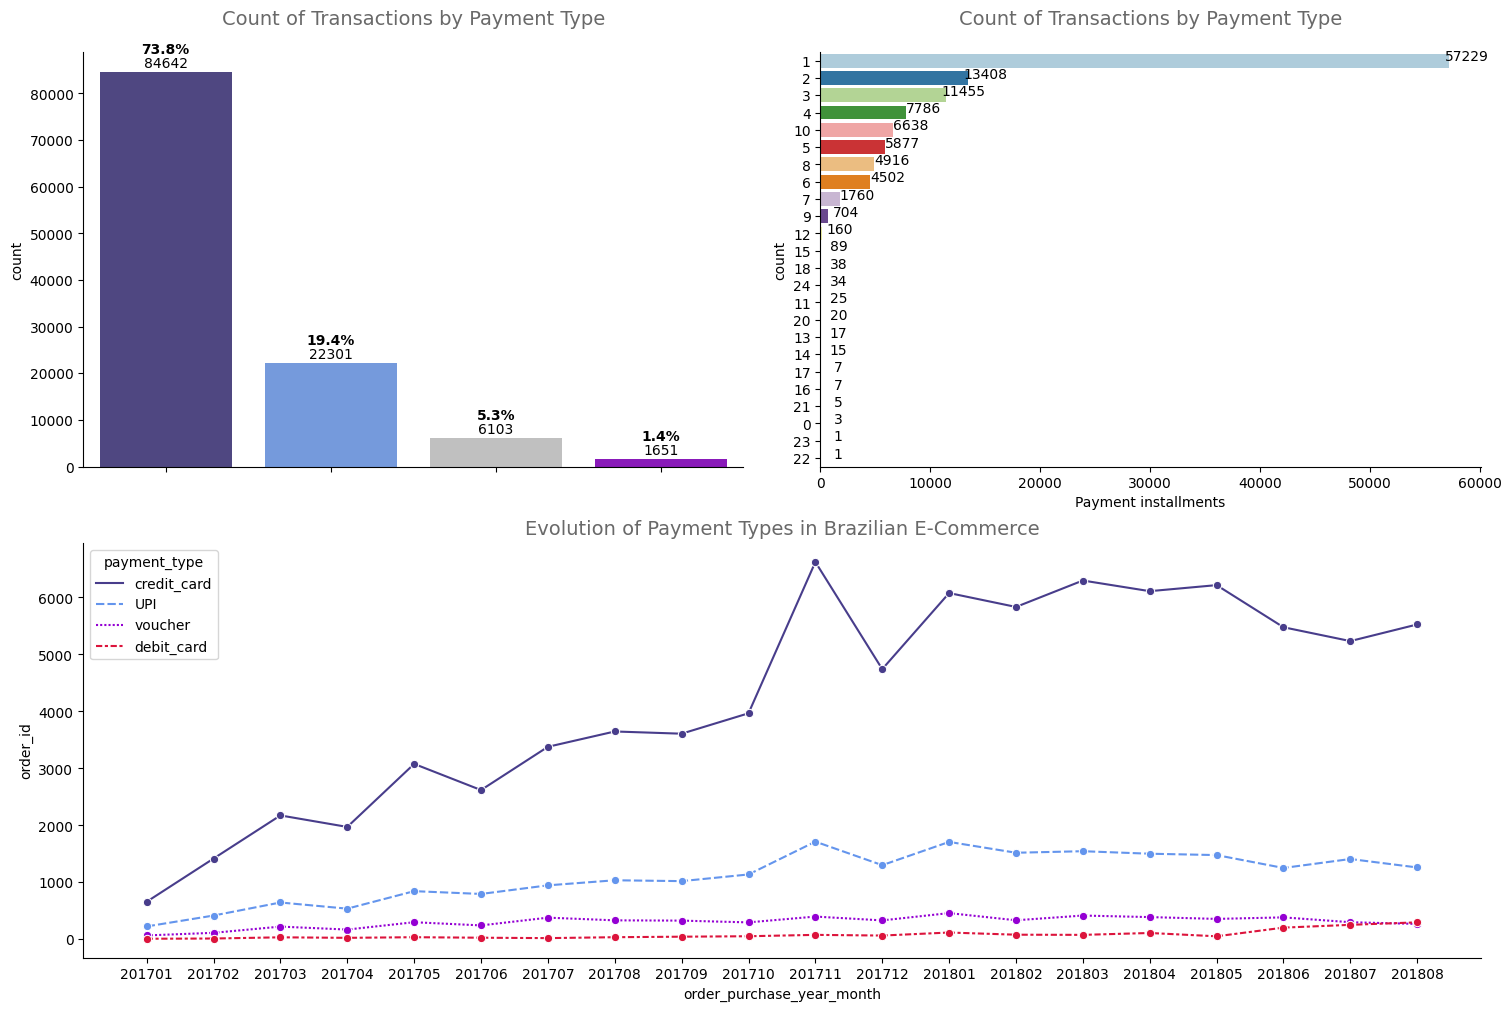

In [561]:
# Grouping data
df_orders_pay = df_orders_filt.merge(Order_payment, how='left', on='order_id')

fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])



# Plot 1 - Payment types in a donut chart
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
sns.despine()
sns.barplot(data = df_orders_pay,y = df_orders_pay['payment_type'].value_counts().values,x =df_orders_pay['payment_type'].value_counts().index ,ax = ax1,palette=colors )
ax1.set_xticklabels("")
ax1.set_ylabel("count")
ax1.set_title('Count of Transactions by Payment Type', size=14, color='dimgrey', pad=20)
# add count and percentage on annotation bar
for i,v in enumerate(df_orders_pay['payment_type'].value_counts().values):
    ax1.text(i,v+1000,str(v),ha ="center")
# adding percentage
    total = df_orders_pay['payment_type'].value_counts().values.sum()
    percentage = (v/total)*100
    ax1.text(i,v+4000, f"{percentage:.1f}%",ha ="center",fontweight="bold")
    
# Plot 2 - Payment installments

sns.barplot(data = df_orders_pay, y= df_orders_pay['payment_installments'].value_counts().sort_index().index, x = df_orders_pay['payment_installments'].value_counts().values, ax = ax2, palette = "Paired", orient= "h")
label = df_orders_pay['payment_installments'].value_counts().index
ax2.set_yticklabels(label)
ax2.set_ylabel("count")
ax2.set_xlabel("Payment installments")
ax2.set_title('Count of Transactions by Payment Type', size=14, color='dimgrey', pad=20)
# add count  on annotation bar
for i,v in enumerate(df_orders_pay['payment_installments'].value_counts().values):
    ax2.text(v+1600,i,str(v),ha ="center")


# Plot 3 - Evolution of payment types
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
colors = ['darkslateblue', 'cornflowerblue', 'darkviolet', 'crimson']
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', palette=colors, marker='o')
ax3.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=14, color='dimgrey')
plt.show()



In fact, we can see by the line chart that payments made by credit card really took marjority place on indian e-commerce. Besides that, since 2018-03 it's possible to see a little decrease on this type of payment. By the other side, payments made by debit card is showing a growing trend since 2018-05, wich is a good opportunity for investor to improve services for payments like this.

On the bar chart above, we can see how brazilian customers prefer to pay the orders: mostly of them pay once into 1 installment and it's worth to point out the quantity of payments done by 10 installments.